# Accuracy of models using Lenskit

This notebook shows how to test the recommendations accuracy of models using lenskit.

## Setup

In [1]:
from lenskit.datasets import MovieLens
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn, basic
import lenskit.metrics.predict as pm
import pandas as pd

/Users/carlos/anaconda3/lib/python3.7/site-packages/fastparquet/encoding.py:222: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  Numpy8 = numba.jitclass(spec8)(NumpyIO)
/Users/carlos/anaconda3/lib/python3.7/site-packages/fastparquet/encoding.py:224: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  Numpy32 = numba.jitclass(spec32)(NumpyIO)
/Users/carlos/anaconda3/lib/python3.7/site-packages/fastparquet/datafr

## Load data

In [3]:
mlens = MovieLens('data/ml-latest-small')
ratings = mlens.ratings
ratings.head()

,user,item,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


## Define algorithms

In [4]:
biasedmf = als.BiasedMF(50)
bias = basic.Bias()
itemitem = item_knn.ItemItem(20)

## Evaluate recommendations

In [5]:
def create_recs(name, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = name
    return recs

We loop over the data to generate recommendations for the defined algorithms.

In [6]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(create_recs('ItemItem', itemitem, train, test))
    all_recs.append(create_recs('BiasedMF', biasedmf, train, test))
    all_recs.append(create_recs('Bias', bias, train, test))    

We create a single data frame with the recommendations

In [7]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,3171,5.366279,9,1,ItemItem
1,104283,5.279667,9,2,ItemItem
2,27803,5.105468,9,3,ItemItem
3,4338,5.037831,9,4,ItemItem
4,86000,4.991602,9,5,ItemItem


We also concatenate the test data

In [8]:
test_data = pd.concat(test_data, ignore_index=True)

Let's analyse the recommendation lists

In [9]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs  ndcg
Algorithm user             
Bias      1     100.0   0.0
          2     100.0   0.0
          3     100.0   0.0
          4     100.0   0.0
          5     100.0   0.0

Let's see the nDCG mean value for each algorithm

In [10]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
Bias        0.000309
BiasedMF    0.069957
ItemItem    0.005367
Name: ndcg, dtype: float64

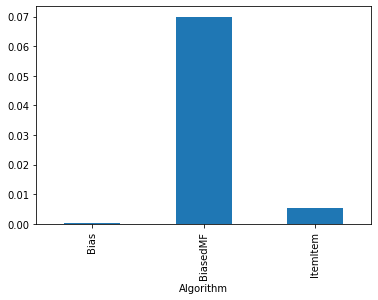

In [11]:
results.groupby('Algorithm').ndcg.mean().plot.bar()

## Evaluate prediction accuracy

In [12]:
def evaluate_predictions(name, algo, train, test):
    algo_cloned = util.clone(algo)
    algo_cloned.fit(train)
    return test.assign(preds=algo_cloned.predict(test), algo=name)

In [13]:
preds_bias = pd.concat(evaluate_predictions('bias', bias, train, test) for (train, test) in xf.partition_users(ratings, 5, xf.SampleFrac(0.2)))
preds_biasedmf = pd.concat(evaluate_predictions('biasedmf', biasedmf, train, test) for (train, test) in xf.partition_users(ratings, 5, xf.SampleFrac(0.2)))
preds_itemitem = pd.concat(evaluate_predictions('itemitem', itemitem, train, test) for (train, test) in xf.partition_users(ratings, 5, xf.SampleFrac(0.2)))

### Bias

In [14]:
print(f'MAE: {pm.mae(preds_bias.preds, preds_bias.rating)}')  
print(f'RMSE: {pm.rmse(preds_bias.preds, preds_bias.rating)}')  

MAE: 0.6950106667260073
RMSE: 0.9066546007561017


### BiasedMF

In [15]:
print(f'MAE: {pm.mae(preds_biasedmf.preds, preds_biasedmf.rating)}')  
print(f'RMSE: {pm.rmse(preds_biasedmf.preds, preds_biasedmf.rating)}')  

MAE: 0.6818618886318303
RMSE: 0.8911595961607526


### ItemItem

In [16]:
print(f'MAE: {pm.mae(preds_itemitem.preds, preds_itemitem.rating)}')  
print(f'RMSE: {pm.rmse(preds_itemitem.preds, preds_itemitem.rating)}')  

MAE: 0.6640965754633255
RMSE: 0.8730680515165724
